In [1]:
import os
import sys
import csv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import glob
import cv2
from keras import layers
from sklearn.model_selection import train_test_split
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.losses import mse
from keras import backend as K
from keras import models

from sklearn.svm import OneClassSVM

In [2]:
%%time
X_list = glob.glob('bottle/train/good/*.png')
Y_list1 = glob.glob('bottle/test/broken_large/*.png')
Y_list2 = glob.glob('bottle/test/broken_small/*.png')
Y_list3 = glob.glob('bottle/test/contamination/*.png')
Y_list4 = glob.glob('bottle/test/good/*.png')
X_train = None
X_test_good = None
X_test_error = None
for X_file in X_list:
  im = cv2.imread(X_file)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  im = cv2.resize(im, (256,256))
  im = im.reshape(1,im.shape[0],im.shape[1],im.shape[2])
  if X_train is not None:
    X_train = np.concatenate((X_train, im))
  if X_train is None:
    X_train = im

for Y_file in Y_list1:
  im = cv2.imread(Y_file)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  im = cv2.resize(im, (256,256))
  im = im.reshape(1,im.shape[0],im.shape[1],im.shape[2])
  if X_test_error is not None:
    X_test_error = np.concatenate((X_test_error, im))
  if X_test_error is None:
    X_test_error = im

for Y_file in Y_list2:
  im = cv2.imread(Y_file)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  im = cv2.resize(im, (256,256))
  im = im.reshape(1,im.shape[0],im.shape[1],im.shape[2])
  if X_test_error is not None:
    X_test_error = np.concatenate((X_test_error, im))
  if X_test_error is None:
    X_test_error = im

for Y_file in Y_list3:
  im = cv2.imread(Y_file)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  im = cv2.resize(im, (256,256))
  im = im.reshape(1,im.shape[0],im.shape[1],im.shape[2])
  if X_test_error is not None:
    X_test_error = np.concatenate((X_test_error, im))
  if X_test_error is None:
    X_test_error = im

for Y_file in Y_list4:
  im = cv2.imread(Y_file)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  im = cv2.resize(im, (256,256))
  im = im.reshape(1,im.shape[0],im.shape[1],im.shape[2])
  if X_test_good is not None:
    X_test_good = np.concatenate((X_test_good, im))
  if X_test_good is None:
    X_test_good = im
    
X_train = X_train/255
X_test_good = X_test_good/255
X_test_error = X_test_error/255
x_train, x_test = train_test_split(X_train, test_size=0.2)

CPU times: total: 13.9 s
Wall time: 19.4 s


In [3]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
latent_dim = 2

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def predict(self, x):
        z_mean, _, _ = self.encoder.predict(x)
        y = self.decoder.predict(z_mean)
        return y

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [5]:
encoder_inputs = keras.Input(shape=(256, 256, 3))
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', data_format=None)(x)
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', data_format=None)(x)
x = layers.Conv2D(16, 3, activation="relu", strides=2, padding="same")(x)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid', data_format=None)(x)
x = layers.Conv2D(3, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
# x = layers.Dense(256, activation='relu')(x)
# x = layers.Dense(64, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 128, 128, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 64, 64, 64)  0           ['conv2d_4[0][0]']               
                                                                                            

In [8]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(12, activation="relu")(latent_inputs)
# x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(2*2*3, activation="relu")(x)
x = layers.Reshape((2, 2, 3))(x)
x = layers.Conv2DTranspose(16, 3, activation="relu", strides=2, padding="same")(x)
x = layers.UpSampling2D(size=(2, 2))(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = layers.UpSampling2D(size=(2, 2))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.UpSampling2D(size=(2, 2))(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="relu", strides=2, padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_6 (Dense)             (None, 12)                36        
                                                                 
 dense_7 (Dense)             (None, 12)                156       
                                                                 
 reshape_2 (Reshape)         (None, 2, 2, 3)           0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 4, 4, 16)         448       
 ranspose)                                                       
                                                                 
 up_sampling2d_1 (UpSampling  (None, 8, 8, 16)         0         
 2D)                                                       

In [9]:
%%time
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(x_train, epochs=30, batch_size=32)

Epoch 1/30
6/6 [==============================] - 15s 1s/step - loss: 303947.9085 - reconstruction_loss: 247054.5156 - kl_loss: 0.1024
Epoch 2/30
6/6 [==============================] - 8s 1s/step - loss: 166240.3326 - reconstruction_loss: 162127.3750 - kl_loss: 0.4170
Epoch 3/30
6/6 [==============================] - 8s 1s/step - loss: 146241.1763 - reconstruction_loss: 143392.0469 - kl_loss: 0.8547
Epoch 4/30
6/6 [==============================] - 8s 1s/step - loss: 128626.1138 - reconstruction_loss: 124760.1797 - kl_loss: 3.4960
Epoch 5/30
6/6 [==============================] - 8s 1s/step - loss: 101986.9018 - reconstruction_loss: 95683.7188 - kl_loss: 32.6609
Epoch 6/30
6/6 [==============================] - 7s 1s/step - loss: 83749.1652 - reconstruction_loss: 83050.7109 - kl_loss: 134.0853
Epoch 7/30
6/6 [==============================] - 7s 1s/step - loss: 71272.6261 - reconstruction_loss: 70924.9766 - kl_loss: 80.7126
Epoch 8/30
6/6 [==============================] - 8s 1s/step -

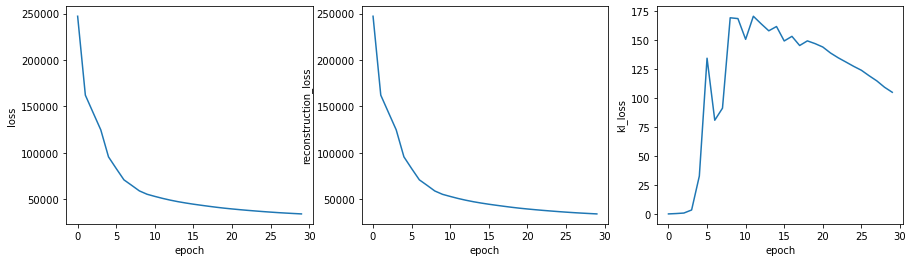

In [10]:
row = 1
col = 3
fig, ax = plt.subplots(row, col, figsize=(15,4))
ax[0].plot(history.history["loss"])
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[1].plot(history.history["reconstruction_loss"])
ax[1].set_ylabel('reconstruction_loss')
ax[1].set_xlabel('epoch')
ax[2].plot(history.history["kl_loss"])
ax[2].set_ylabel('kl_loss')
ax[2].set_xlabel('epoch')
plt.show()

In [11]:
# x_train_f, a, b = vae.encoder.predict(X_train)
# x_test_good_f, _, _ = vae.encoder.predict(X_test_good)
# x_test_error_f, _, _ = vae.encoder.predict(X_test_error)

2/2 [==============================] - 1s 151ms/step


In [18]:
_, _, x_train_f = encoder.predict(X_train)
_, _, x_test_good_f = encoder.predict(X_test_good)
_, _, x_test_error_f = encoder.predict(X_test_error)

2/2 [==============================] - 0s 126ms/step


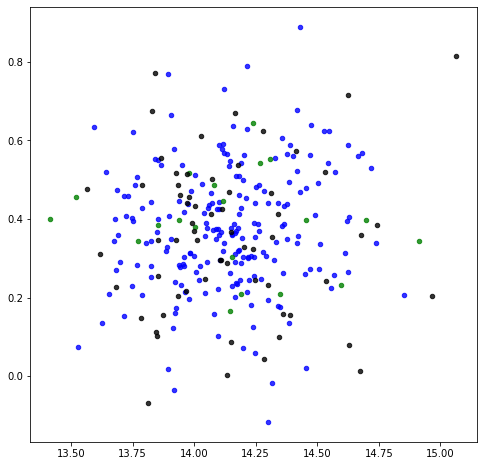

In [21]:
x0 = x_train_f[:, 0]
x1 = x_train_f[:, 1]
y0 = x_test_good_f[:, 0]
y1 = x_test_good_f[:, 1]
z0 = x_test_error_f[:, 0]
z1 = x_test_error_f[:, 1]

plt.figure(figsize=(8, 8))
plt.scatter(x0, x1, alpha=0.8, c='b', s = 20)
plt.scatter(y0, y1, alpha=0.8, c='g', s = 20)
plt.scatter(z0, z1, alpha=0.8, c='black', s = 20)

In [22]:
train_data = x_train_f
test_data_good = x_test_good_f
test_data_error = x_test_error_f

In [23]:
clf = OneClassSVM(nu=0.1, kernel="rbf", gamma=0.01)
clf.fit(train_data)
pred_tr = clf.predict(train_data)
pred_tg = clf.predict(test_data_good)
pred_te = clf.predict(test_data_error)

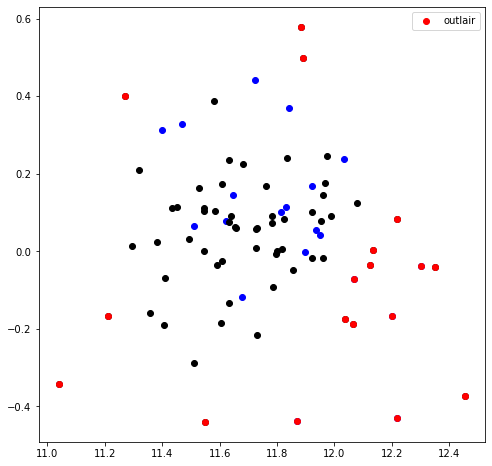

13 50
5 15
accuracy: 0.3373493975903614


In [34]:
index_tr = np.where(pred_tr < 0)
index_tg = np.where(pred_tg < 0)
index_te = np.where(pred_te < 0)

plt.figure(figsize=(8, 8))
# plt.scatter(train_data[:,0], train_data[:,1], c='b')
# plt.scatter(train_data[index_tr, 0], train_data[index_tr, 1], c='red')

plt.scatter(test_data_good[:,0], test_data_good[:,1], c='b')
plt.scatter(test_data_good[index_tg, 0], test_data_good[index_tg, 1], c='red', label='outlair')

plt.scatter(test_data_error[:,0], test_data_error[:,1], c='black')
plt.scatter(test_data_error[index_te, 0], test_data_error[index_te, 1], c='red')
plt.legend()
plt.savefig('OneClassSVM.png')
plt.show()

in_tg = np.array(index_tg)
in_te = np.array(index_te)

a0, b0 = in_tg.shape
a1, b1 = in_te.shape

TN = len(test_data_good) - b0
FP = b0
FN = len(test_data_error) - b1
TP = b1
print(TP, FN)
print(FP, TN)
print('accuracy:',(TP + TN)/(TP+TN+FP+FN)) 

In [30]:
s_v = np.array(clf.support_)
m, n = train_data.shape
SV = []
for i in range(len(s_v)):
    SV.append(list(X_train[s_v[i], :, :, :]))
sv = np.array(SV)

Epoch 1/30
2/2 [==============================] - 1s 342ms/step - loss: 34091.5286 - reconstruction_loss: 33975.8750 - kl_loss: 101.9106
Epoch 2/30
2/2 [==============================] - 1s 320ms/step - loss: 33959.7240 - reconstruction_loss: 33839.0508 - kl_loss: 99.2489
Epoch 3/30
2/2 [==============================] - 1s 324ms/step - loss: 33800.5560 - reconstruction_loss: 33675.7930 - kl_loss: 97.1813
Epoch 4/30
2/2 [==============================] - 1s 306ms/step - loss: 33672.1589 - reconstruction_loss: 33531.5625 - kl_loss: 94.7857
Epoch 5/30
2/2 [==============================] - 1s 358ms/step - loss: 33545.1901 - reconstruction_loss: 33435.5703 - kl_loss: 93.1890
Epoch 6/30
2/2 [==============================] - 1s 309ms/step - loss: 33444.9583 - reconstruction_loss: 33363.5000 - kl_loss: 90.3355
Epoch 7/30
2/2 [==============================] - 1s 268ms/step - loss: 33319.7591 - reconstruction_loss: 33205.6836 - kl_loss: 89.0970
Epoch 8/30
2/2 [==============================]

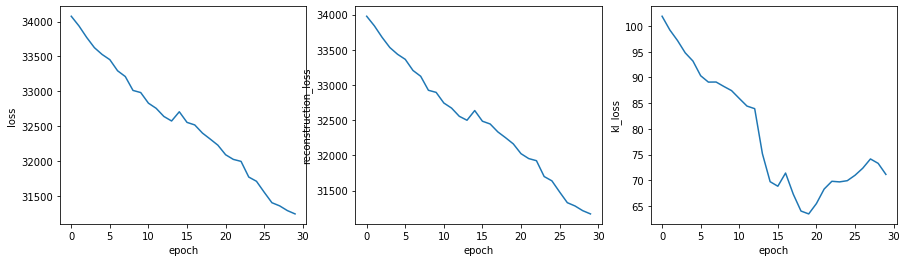

2/2 [==============================] - 0s 163ms/step
CPU times: total: 1min 35s
Wall time: 38 s


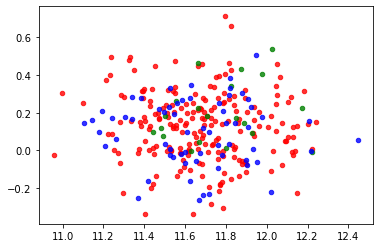

In [31]:
%%time
history = vae.fit(sv, epochs=30, batch_size=16)

row = 1
col = 3
fig, ax = plt.subplots(row, col, figsize=(15,4))
ax[0].plot(history.history["loss"])
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[1].plot(history.history["reconstruction_loss"])
ax[1].set_ylabel('reconstruction_loss')
ax[1].set_xlabel('epoch')
ax[2].plot(history.history["kl_loss"])
ax[2].set_ylabel('kl_loss')
ax[2].set_xlabel('epoch')
plt.show()

2/2 [==============================] - 0s 123ms/step


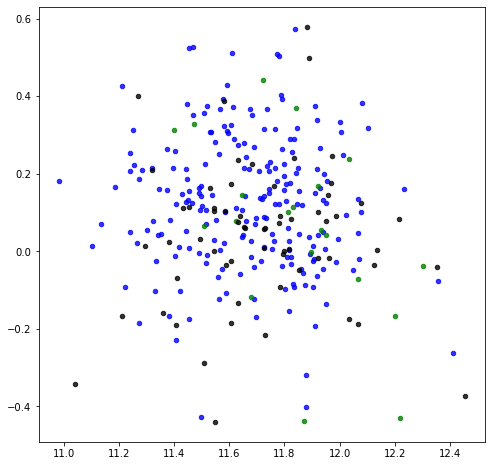

In [32]:
_, _, x_train_f = encoder.predict(X_train)
_, _, x_test_good_f = encoder.predict(X_test_good)
_, _, x_test_error_f = encoder.predict(X_test_error)

x0 = x_train_f[:, 0]
x1 = x_train_f[:, 1]
y0 = x_test_good_f[:, 0]
y1 = x_test_good_f[:, 1]
z0 = x_test_error_f[:, 0]
z1 = x_test_error_f[:, 1]

plt.figure(figsize=(8, 8))
plt.scatter(x0, x1, alpha=0.8, c='b', s = 20)
plt.scatter(y0, y1, alpha=0.8, c='g', s = 20)
plt.scatter(z0, z1, alpha=0.8, c='black', s = 20)

train_data = x_train_f
test_data_good = x_test_good_f
test_data_error = x_test_error_f

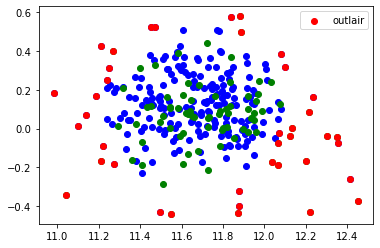

13 50
5 15
accuracy: 0.3373493975903614
CPU times: total: 500 ms
Wall time: 1.15 s


In [35]:
%%time
clf.fit(train_data)
pred_tr = clf.predict(train_data)
pred_tg = clf.predict(test_data_good)
pred_te = clf.predict(test_data_error)

index_tr = np.where(pred_tr < 0)
index_tg = np.where(pred_tg < 0)
index_te = np.where(pred_te < 0)

plt.scatter(train_data[:,0], train_data[:,1], c='b')
plt.scatter(train_data[index_tr, 0], train_data[index_tr, 1], c='red', label='outlair')

plt.scatter(test_data_good[:,0], test_data_good[:,1], c='g')
plt.scatter(test_data_good[index_tg, 0], test_data_good[index_tg, 1], c='red')

plt.scatter(test_data_error[:,0], test_data_error[:,1], c='g')
plt.scatter(test_data_error[index_te, 0], test_data_error[index_te, 1], c='red')
plt.legend()
plt.savefig('OneClassSVM.png')
plt.show()

in_tg = np.array(index_tg)
in_te = np.array(index_te)

a0, b0 = in_tg.shape
a1, b1 = in_te.shape

TN1 = len(test_data_good) - b0
FP1 = b0
FN1 = len(test_data_error) - b1
TP1 = b1
print(TP1, FN1)
print(FP1, TN1)
print('accuracy:',(TP + TN)/(TP+TN+FP+FN)) 